<a href="https://colab.research.google.com/github/AravaChoudhary/ML-Pipeline-/blob/main/ML_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# using API to fetch the dataset
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 95% 77.0M/80.9M [00:01<00:00, 71.5MB/s]
100% 80.9M/80.9M [00:01<00:00, 68.5MB/s]


In [4]:
# extracting the compressed dataset from zip file
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'
with ZipFile(dataset , 'r') as zip:
  zip.extractall()
  print('The Dataset is Extracted')

The Dataset is Extracted


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [6]:
import nltk
nltk.download('stopwords')

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Data Processing
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv' , encoding = 'ISO-8859-1') # Corrected encoding name


In [8]:
twitter_data.shape

(1599999, 6)

In [9]:
twitter_data.head(4)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
# naming the columns and reading the dataset again
column_names = ['target','id','date','flag','user','text']

twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv' , names = column_names , encoding = 'ISO-8859-1')
print(twitter_data.shape)
twitter_data.head()

(1600000, 6)


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
twitter_data.isnull().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [13]:
twitter_data.target.value_counts()

,count
target,
0,800000
4,800000


In [14]:
# converting 4 --> 1
twitter_data.replace({'target' : {4:1}}, inplace = True)
twitter_data.target.value_counts()

,count
target,
0,800000
1,800000


In [15]:
# Stemming
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

port_stem = PorterStemmer()

def stemming(text):
  stemmed_text = re.sub('[^a-zA-Z]',' ',text)
  stemmed_text = stemmed_text.lower()
  stemmed_text = stemmed_text.split()
  stemmed_text = [port_stem.stem(word) for word in stemmed_text if not word in stopwords.words('english')]
  stemmed_text = ' '.join(stemmed_text)

  return stemmed_text

In [17]:
data_label_0 = twitter_data[twitter_data['target'] == 0]
data_label_1 = twitter_data[twitter_data['target'] == 1]

data_sample_0 = data_label_0.sample(n=8000, random_state=1)
data_sample_1 = data_label_1.sample(n=8000, random_state=1)

data_balanced_sample = pd.concat([data_sample_0, data_sample_1])
data_balanced_sample = data_balanced_sample.sample(frac=1, random_state=1).reset_index(drop=True)

data_balanced_sample.target.value_counts()
sample_data = data_balanced_sample.copy()
sample_data.target.value_counts()

,count
target,
0,8000
1,8000


In [18]:
sample_data = twitter_data.sample(frac=0.01, random_state=1)
sample_data

,target,id,date,flag,user,text
514293,0,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...
142282,0,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,So I had a dream last night. I remember a sig...
403727,0,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,0,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again
610789,0,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,@MissKeriBaby wish I was in LA right now
...,...,...,...,...,...,...
133475,0,1836009793,Mon May 18 07:11:45 PDT 2009,NO_QUERY,amjolst,"I really, really don't want to leave him and g..."
638631,0,2234507580,Thu Jun 18 23:11:12 PDT 2009,NO_QUERY,Supertodaininja,only has a measly 7 updates!
740314,0,2265957956,Sun Jun 21 07:38:15 PDT 2009,NO_QUERY,eleonor,had a great time catching up with my close mat...
367475,0,2049203898,Fri Jun 05 16:28:37 PDT 2009,NO_QUERY,candireign,It's pouring outside - this whole rain thing i...


In [19]:
sample_data['stemmed_text'] = sample_data['text'].apply(stemming)

In [21]:
sample_data['stemmed_text']

,stemmed_text
514293,miss nikki nu nu alreadi she alway need thank ...
142282,dream last night rememb sign clearli told get ...
403727,girlyghost ohh poor sickli hug hope feel littl...
649503,rain
610789,misskeribabi wish la right
...,...
133475,realli realli want leav go work
638631,measli updat
740314,great time catch close mate nite dshibi place ...
367475,pour outsid whole rain thing depress fb


In [22]:
X = sample_data['stemmed_text'].values
y = sample_data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2)
X.shape , X_train.shape , X_test.shape

((16000,), (12800,), (3200,))

In [23]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

print("Current Model Performance : ")
print(f"Random Forest - Training Accuracy: {rf_train_accuracy * 100:.2f}%")
print(f"Random Forest - Testing Accuracy: {rf_test_accuracy * 100:.2f}%")

Current Model Performance : 
Random Forest - Training Accuracy: 99.95%
Random Forest - Testing Accuracy: 71.38%


In [27]:
y_pred = rf_model.predict(X_test)
print('\nClassification Report : ')
print(classification_report(y_test,y_pred))
print('\nConfusion Matrix : ')
print(confusion_matrix(y_test,y_pred))


Classification Report : 
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1596
           1       0.74      0.66      0.70      1604

    accuracy                           0.71      3200
   macro avg       0.72      0.71      0.71      3200
weighted avg       0.72      0.71      0.71      3200


Confusion Matrix : 
[[1223  373]
 [ 543 1061]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distributions
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier()

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,n_iter=50, cv=5, verbose=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_:.2f}")

# Use the best estimator from random search
best_rf = random_search.best_estimator_

# Predict and evaluate
train_accuracy = accuracy_score(y_train, best_rf.predict(X_train))
test_accuracy = accuracy_score(y_test, best_rf.predict(X_test))

print(f"Random Forest - Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Random Forest - Testing Accuracy: {test_accuracy * 100:.2f}%")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [28]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


<ipython-input-32-72359459404b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'target' , data = twitter_data , palette = 'coolwarm')


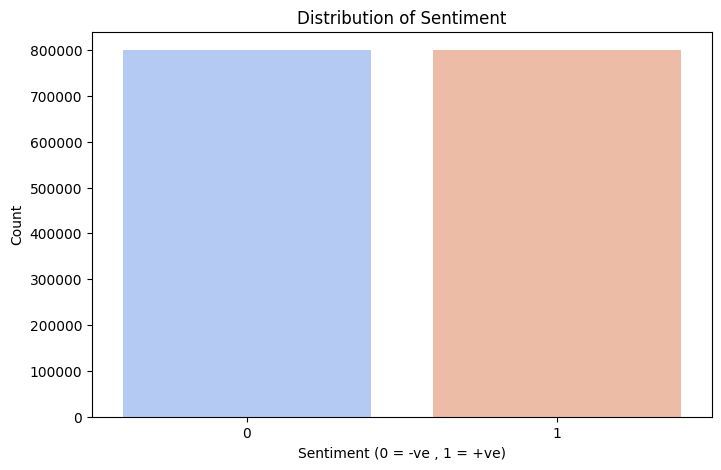

In [32]:
# Univariate Analysis
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x = 'target' , data = twitter_data , palette = 'coolwarm')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment (0 = -ve , 1 = +ve)')
plt.ylabel('Count')
plt.show()

In [33]:
twitter_data.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

<Axes: ylabel='count'>

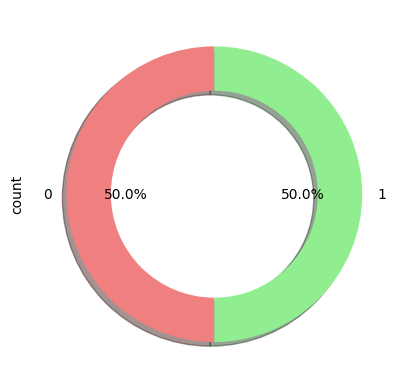

In [40]:
twitter_data['target'].value_counts().plot.pie(autopct='%1.1f%%',
                                     wedgeprops=dict(width=0.3),
                                     colors=['lightcoral','lightgreen'],
                                     startangle=90,
                                     shadow=True)

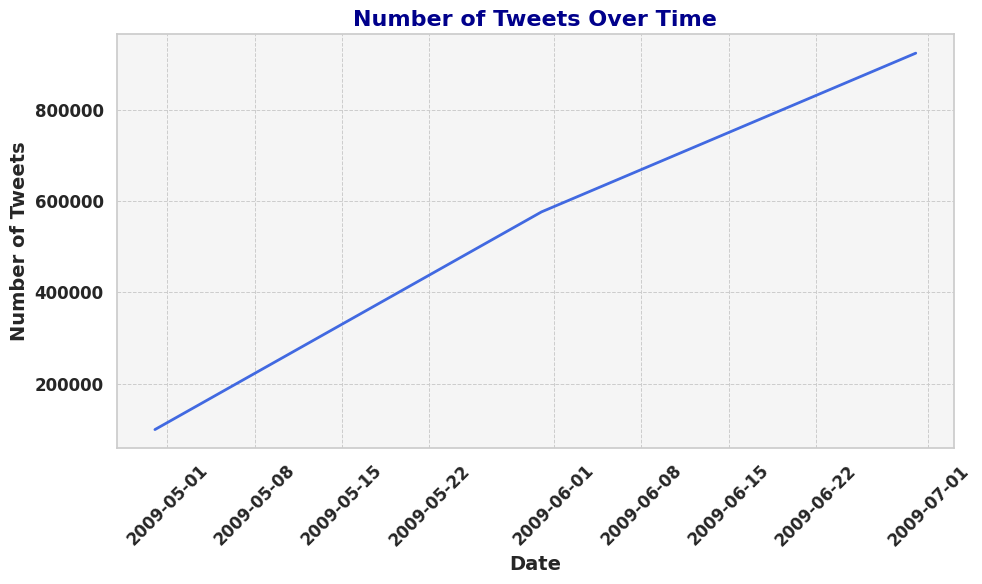

In [45]:
twitter_data['date'] = pd.to_datetime(twitter_data['date'])
monthly_data = twitter_data.resample('M', on='date').size()

plt.figure(figsize=(10,6))

# Using a color palette and adding style
sns.set(style="whitegrid")
sns.lineplot(x=monthly_data.index, y=monthly_data.values, color='royalblue', linewidth=2)

# Customizing title and labels with different font sizes and weights
plt.title('Number of Tweets Over Time', fontsize=16, weight='bold', color='darkblue')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('Number of Tweets', fontsize=14, weight='bold')

# Adjusting the x-ticks rotation and appearance
plt.xticks(rotation=45, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Adding a light grid and customizing the background
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.gca().set_facecolor('whitesmoke')

# Adding space around the plot
plt.tight_layout()

plt.show()

In [47]:
twitter_data

,target,id,date,flag,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,2009-06-16 08:40:49,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,2009-06-16 08:40:49,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,2009-06-16 08:40:49,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,2009-06-16 08:40:49,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


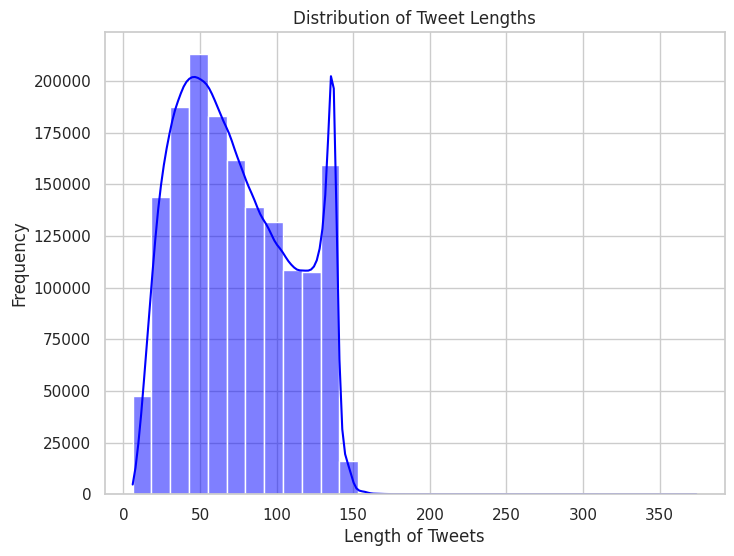

In [50]:
twitter_data['text_length'] = twitter_data['text'].apply(len)

plt.figure(figsize=(8,6))
sns.histplot(twitter_data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()

<ipython-input-52-b72fcca048c2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='text_length', data=twitter_data, palette='coolwarm')


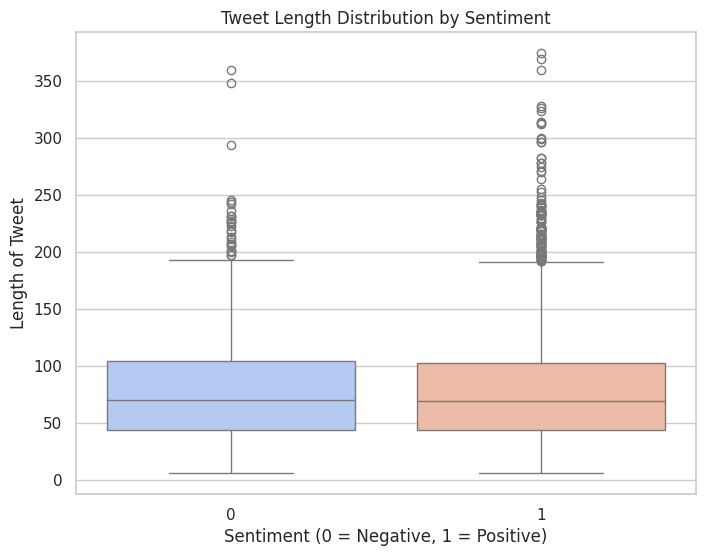

In [52]:
plt.figure(figsize=(8,6))
sns.boxplot(x='target', y='text_length', data=twitter_data, palette='coolwarm')
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Length of Tweet')
plt.show()

<ipython-input-54-c35868ce1444>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hashtags.values, y=hashtags.index, palette='Blues_d')


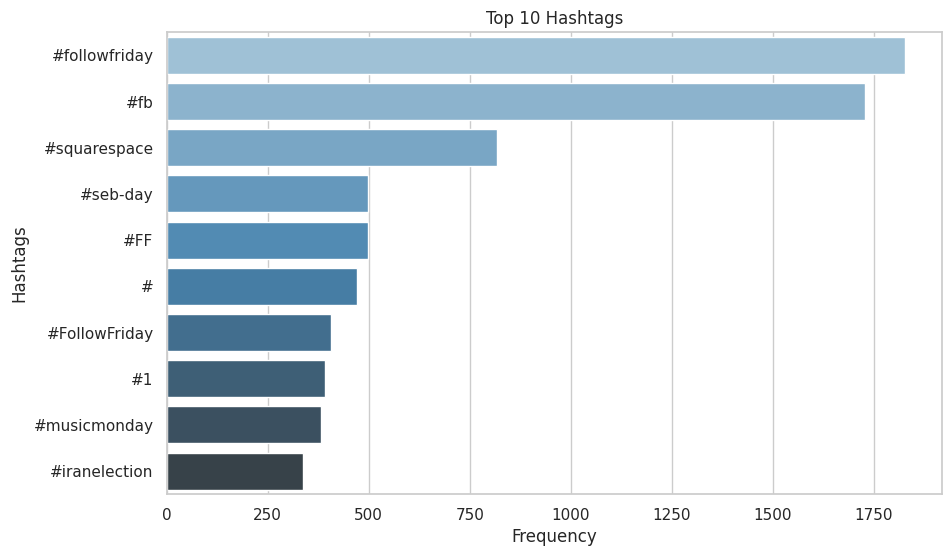

In [54]:
# hashtags
twitter_data['hashtags'] = twitter_data['text'].apply(lambda x: [i for i in x.split() if i.startswith('#')])

hashtags = twitter_data['hashtags'].explode().value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=hashtags.values, y=hashtags.index, palette='Blues_d')
plt.title('Top 10 Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.show()

In [55]:
# Model Saving
import pickle
filename = 'trained_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# Using saved model for future predictions
loaded_model = pickle.load(open('/content/trained_model.sav' , 'rb'))